 **Goal**: create a competive portfolio strategy (with either one of the following objectives)
    1. Max final account balance on 7/1/2018 (in other words,return rate)
    2. Min standard deviation of the daily account balance in the period of 4/1/2018-7/1/2018  (In finace, we use std to represent the portfolio risk level)
**Available raw data**: 
    1. 2 year closing prices and daily volume for 63 stocks (stocks were randomly selected from Small, Mid, Large Cap SP Index)
    2. Time range: 3/1/2016-3/1/2018
    
**Algorithm Testing data and trading rule**
    1. 4/1/2018-7/1/2018 real time prices for the stock pool
    2. For each trade on each stock, a 5 dollars commision fee will be executed. Lot size is immaterial. All transaction fee would be only substracted at the end pf 3-month investing period
    

## Libraries and modules needed

In [5]:
import scipy as sp
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import timedelta
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from scipy.optimize import linprog
from scipy.optimize import minimize 

float_formatter = lambda x:"%.4f" %x if x>=0 else "%.4f"%x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.options.display.float_format='{:20,.4f}'.format

## Importing data and separate training and testing data sets
1. **Raw data**: 3/1/2016--3/1/2018
2. **Algorithm testing data**: 4/1/2018-7/1/2018


In [60]:
#PLease change the data location to make sure it could run successfully
rawdata_price = pd.read_csv("Python Example Cleco/Data/ClosingPriceData(6.30).csv")
#rawdata_volume = pd.read_csv("Python Example Cleco/Data/VolumeData(6.30).csv")
rawdata_price=rawdata_price.drop(["Date"],axis=1);#rawdata_volume=rawdata_volume.drop(["Date"],axis=1)
#Separating available raw data and algorithm testing data
rawdata_price_train =rawdata_price.head(525); #rawdata_volume_train=rawdata_volume.head(525)
rawdata_price_test=rawdata_price.tail(64);#rawdata_volume_test = rawdata_volume.tail(64)

In [61]:
rawdata_price.shape

(589, 63)

## Using RNN to predict future stock prices 
* Importing the Keras Sequential model since our RNN will be in order
* Importing the Dense Layers for nodes
* Applying LSTM layer for time series
* In this example, we will only use today's stock price (P_t) as the only input, and the output Y will be the tomorrow's stock price (P_t+1) 
* **Feature selection for RNN models**:
    * Feature Seletion could be another whole charper discussion, but won't be included in this example. 
    * Parameters for the model also could be another whole chapter discussion, so the selection for optimal parameters also won't be discussed here.
    * **Possible Features (inputs)**
        * today's stock price (only 1 input)
        * today's stock volume (only 1 input)
        * last weeks' stocks prices (5 inputs)
        * last weeks' stock volume (5 inputs)
        * today's stock price + today's stock volume (2 inputs)
        * any other possible combinations

In [62]:
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM

In [63]:
class RNNPredictionModel():
    def features(self,df,timeinterval):
        #Parameters
        Rows=len(df)
        #Define features
        feature = pd.DataFrame(df[:-timeinterval])
        feature.columns=["Feature Input"]
        return feature
    
    def output_y(self,df,timeinterval):
        Output_y=pd.DataFrame(df[timeinterval:])
        Output_y.columns=["Output Y"]
        return Output_y


    def generate_one_dataframe(self,df,timeinterval):
        n= df.shape[0]
        train_start = 0; train_end = 525
        test_start = train_end;test_end=n
        data_train=df[train_start:train_end]
        data_test=df[test_start:test_end]
        # we have to scale all data in the same numerical level
        scaler=MinMaxScaler()
        scaler.fit(data_train)
        data_train=scaler.transform(data_train);data_test=scaler.transform(data_test)
        # training data
        x_train=data_train[:-1];y_train=data_train[1:]
        rows_train=x_train.shape[0]
        #testing data
        x_test=data_test[:-1];y_test=data_test[1:]
        rows_test=x_test.shape[0]
        # Reshaping data into three dimensions: [batch size,timesteps,input_dim]
        # batch size= rows_train; timesteps=1,input_dim=#features=1
        x_train=np.reshape(x_train,(rows_train,1,1))
        x_test=np.reshape(x_test,(rows_test,1,1))
        #Initializing the RNN, and call it regressor 
        regressor=tf.keras.Sequential()
        #Adding input layer and the lSTM layer
        regressor.add(tf.keras.layers.LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
        regressor.add(tf.keras.layers.LSTM(units=4,return_sequences=True))
        regressor.add(tf.keras.layers.LSTM(units=4))
        #Adding output layer 
        regressor.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
        #Compiling the RNN 
        regressor.compile(loss='mean_squared_error',optimizer='adam')
        #Fitting the RNN to the training set 
        regressor.fit(x_train,y_train,batch_size=32,epochs=300)
        predicted_scaled=regressor.predict(x_test)
        predicted_reversed=scaler.inverse_transform(predicted_scaled)
        Predicted_reversed_final=pd.DataFrame(predicted_reversed,columns=df.columns)
        
        return Predicted_reversed_final

    def generate_final_dataframe(self):
        predictedResult_all=pd.DataFrame()
        for stockname in rawdata_price.columns:
            df=rawdata_price[[stockname]]
            timeinterval=1
            predictedResult_onestock= self.generate_one_dataframe(df,timeinterval)
            predictedResult_all=pd.concat((predictedResult_all,predictedResult_onestock),axis=1)
            
        return predictedResult_all
    

In [ ]:
# Generating all predicted prices for all stocks
Predictions=RNNPredictionModel().generate_final_dataframe()
# Export results to cvs
Predictions.to_csv("PredictionPrices.csv")

### Visulization results of one stock to see the accuracy level of the RNN prediction model
* Example: Stock "GE"
* Comparing the predicted prices to the real prices

In [ ]:
df=rawdata_price[["GE"]]
n= df.shape[0]
train_start = 0; train_end = 525
test_start = train_end;test_end=n
data_train=df[train_start:train_end]
data_test=df[test_start:test_end]
# we have to scale all data in the same numerical level
scaler=MinMaxScaler()
scaler.fit(data_train)
data_train=scaler.transform(data_train);data_test=scaler.transform(data_test)
# training data
x_train=data_train[:-1];y_train=data_train[1:]
rows_train=x_train.shape[0]
#testing data
x_test=data_test[:-1];y_test=data_test[1:]
rows_test=x_test.shape[0]
x_train=np.reshape(x_train,(rows_train,1,1))
x_test=np.reshape(x_test,(rows_test,1,1))
#Initializing the RNN, and call it regressor 
regressor=tf.keras.Sequential()
#Adding input layer and the lSTM layer
regressor.add(tf.keras.layers.LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
regressor.add(tf.keras.layers.LSTM(units=4,return_sequences=True))
regressor.add(tf.keras.layers.LSTM(units=4))
#Adding output layer 
regressor.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
#Compiling the RNN 
regressor.compile(loss='mean_squared_error',optimizer='adam')
#Fitting the RNN to the training set 
regressor.fit(x_train,y_train,batch_size=32,epochs=300)
predicted_scaled=regressor.predict(x_test)
predicted_reversed=scaler.inverse_transform(predicted_scaled)

In [65]:
real_scaled = y_test
real_price = scaler.inverse_transform(y_test)
results_comparison= pd.concat([pd.DataFrame(predicted_reversed,columns =['Prediction']),pd.DataFrame(real_price,columns=['RealPrice'])],axis=1)
results_comparison.head()

,Prediction,RealPrice
0,13.9696,13.1300
1,13.9719,13.2800
2,14.0080,13.4300
3,14.0487,13.0600
4,13.9566,12.8300


### Visualization: real vs predicteed

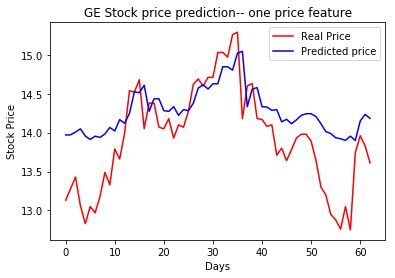

In [66]:
plt.plot(real_price, color = 'red',label = 'Real Price')
plt.plot(predicted_reversed,color = 'blue',label= 'Predicted price')
plt.title('GE Stock price prediction-- one price feature')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**Using the predicted prices to build portfolio simulation model**
* daily return rate = $\frac{P_t}{P_{t-1}}-1$
* E(Return) = $\frac{\sum_t R_t}{T}$
* Variance = $W^T * \Sigma * W$

Text(0, 0.5, 'Returns')

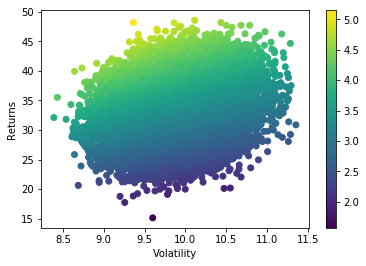

In [68]:
#calculate the daily return rate
returns =(Predictions.pct_change()*100)[1:]
mean_daily_returns=returns.mean() #stock mean 
#calculate the covariance matrix for the return rate
cov_matrix = returns.cov()
#set the simulation times fot random portfolio weights
num_simulation=50000
results=np.zeros((66,num_simulation))
#calculte the return and volatility for each possible portfolio combination
for i in range(num_simulation):
    weights= np.array(np.random.random(63))
    weights/=np.sum(weights)
    #calculate yearly return and volatility 
    portfolio_return = np.sum(mean_daily_returns*weights)*252
    portfolio_std = np.sqrt(252 * np.dot(weights.T,np.dot(cov_matrix,weights)))
    
    #Store results
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std
    ### sharp ratio = return / std
    results[2,i] = results[0,i]/results[1,i]

    ####adding weights columns
    for j in range(len(weights)):
        results[j+3,i]=weights[j]

    # DataFrame
    a2=['return','std','sharpe']
    a1=list(Predictions.columns.values)
    results_frame = pd.DataFrame(results.T,columns =a2+a1)
####locate positions of portfolio with the highest sharp ratio
max_sharpe_ratio = results_frame.loc[results_frame['sharpe']==max(results_frame['sharpe'])]
#max_sharp_ratio=np.asanyarray(max_sharp_ratio)
min_vol_port = results_frame.loc[results_frame['std']==min(results_frame['std'])]
# max return
max_return_port = results_frame.loc[results_frame['return']==max(results_frame['return'])]

# Create scatter plot colored by Sharp Ratio
plt.scatter(results_frame['std'],results_frame['return'],c=results_frame['sharpe'],cmap='viridis')
plt.colorbar()  
plt.xlabel('Volatility')
plt.ylabel('Returns')

In [69]:
# Selecting the portfolio with Min Std
min_std=results_frame.loc[results_frame['std']==min(results_frame['std'])]
real_weights=min_std.drop(['return','std','sharpe'],axis=1)
print(real_weights.shape)
account_share = np.array(real_weights*100000)/np.array(Predictions.head(1))
account_balance = np.dot(np.array(Predictions),account_share.T)
#Deducting the comnission fee for trading 63 stocks at the 1st trading day  
account_balance[0] = 100000-63*5
account_change = (pd.DataFrame(account_balance).pct_change()*100)[1:]
np.std(account_change)

(1, 63)


0                 0.5395
dtype: float64

### Conclusion 
 * Portfolio Weights using our strategy

In [70]:
real_weights

,GE,MMM,JNJ,PFE,AAPL,GOOGL,AMZN,CMCSA,NEE,DUK,...,IRDM,DWDP,SAFM,SF,ODFL,OGE,BCOR,SXI,PCH,IVR
49227,0.0204,0.0119,0.0115,0.0247,0.0188,0.0144,0.0121,0.0140,0.0187,0.0292,...,0.0254,0.0166,0.0166,0.0022,0.0310,0.0111,0.0043,0.0123,0.0290,0.0293
